by tutorial https://pytorch.org/tutorials/beginner/transformer_tutorial.html

# v1 Baseline - tutorial

Language Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on training a sequence-to-sequence model that uses the
`nn.Transformer <https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>`__ module.

The PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You Need <https://arxiv.org/pdf/1706.03762.pdf>`__.
Compared to Recurrent Neural Networks (RNNs), the transformer model has proven
to be superior in quality for many sequence-to-sequence tasks while being more
parallelizable. The ``nn.Transformer`` module relies entirely on an attention
mechanism (implemented as
`nn.MultiheadAttention <https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html>`__)
to draw global dependencies between input and output. The ``nn.Transformer``
module is highly modularized such that a single component (e.g.,
`nn.TransformerEncoder <https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html>`__)
can be easily adapted/composed.

![](../_static/img/transformer_architecture.jpg)
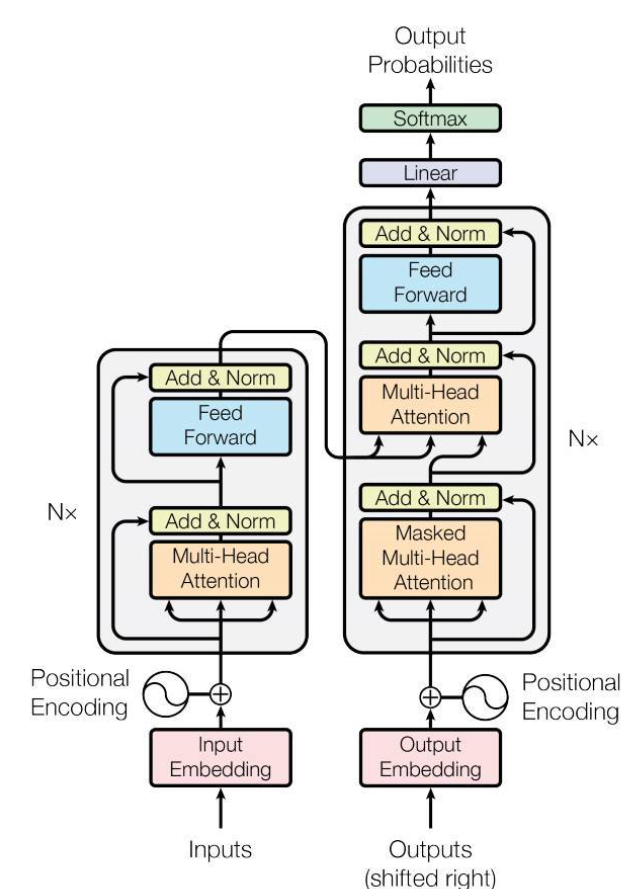



Setup & Import
----------------

In [ ]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import numpy as np

In [ ]:
%matplotlib inline

In [ ]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the model
----------------




In this tutorial, we train a ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html>`__.
Along with the input sequence, a square attention mask is required because the
self-attention layers in ``nn.TransformerEncoder`` are only allowed to attend
the earlier positions in the sequence. For the language modeling task, any
tokens on the future positions should be masked. To produce a probability
distribution over output words, the output of the ``nn.TransformerEncoder``
model is passed through a linear layer followed by a log-softmax function.




In [ ]:


class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
            # d_model – the number of expected features in the input (required).
            # nhead – the number of heads in the multiheadattention models (required).
            # d_hid - dim_feedforward – the dimension of the feedforward network model (default=2048).
            # dropout – the dropout value (default=0.1).
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output
        # torch.nn.functional.softmax(input, dim=None, _stacklevel=3, dtype=None)
        # F.softmax(input, dim=None, _stacklevel=3, dtype=None)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset.
To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data. 

The vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Wikitext-2 represents rare tokens as `<unk>`.

Given a 1-D vector of sequential data, ``batchify()`` arranges the data
into ``batch_size`` columns. If the data does not divide evenly into
``batch_size`` columns, then the data is trimmed to fit. For instance, with
the alphabet as the data (total length of 26) and ``batch_size=4``, we would
divide the alphabet into 4 sequences of length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

Batching enables more parallelizable processing. However, batching means that
the model treats each column independently; for example, the dependence of
``G`` and ``F`` can not be learned in the example above.




In [ ]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    # t() 0-D and 1-D tensors are returned as is. When input is a 2-D tensor this is equivalent to transpose(input, 0, 1).
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

Functions to generate input and target sequence




``get_batch()`` generates a pair of input-target sequences for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

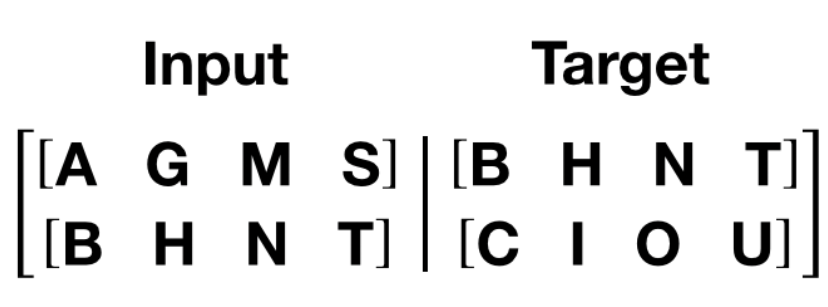!

It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [ ]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
# max string length
print([max([len(d)  for d in w ]) for w in WikiText2()]) # 0 train, 1 val, 2 test

[3837, 2210, 2539]

In [ ]:
# max num words in strings
print([max([len(d.split())  for d in w ]) for w in WikiText2()]) # 0 train, 1 val, 2 test

[699, 429, 481]


In [ ]:
t = iter(WikiText2()[0])
next(t), next(t), next(t), next(t), 

#WikiText2()[0][0]

(' \n',
 ' = Valkyria Chronicles III = \n',
 ' \n',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n')

In [ ]:
len(test_data), len(train_data), test_data[0], get_batch(test_data,0)[0].size(), get_batch(test_data,0)[1].size()

(24185,
 102499,
 tensor([   9,  292,  591, 5361,    5,   46,    9,    3,   10, 5060]),
 torch.Size([35, 10]),
 torch.Size([350]))

Initiate an instance
--------------------




The model hyperparameters are defined below. The vocab size is
equal to the length of the vocab object.




In [ ]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
# ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.5

In [ ]:
ntokens

28782

Function train & evaluate
-------------




We use `CrossEntropyLoss <https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html>`__
with the `SGD <https://pytorch.org/docs/stable/generated/torch.optim.SGD.html>`__
(stochastic gradient descent) optimizer. The learning rate is initially set to
5.0 and follows a `StepLR <https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html>`__
schedule. During training, we use `nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html>`__
to prevent gradients from exploding.




In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            # Perplexity
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

## Train model

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [ ]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 15.81 | loss  8.16 | ppl  3484.28
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 14.75 | loss  6.87 | ppl   964.61
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 14.78 | loss  6.44 | ppl   625.48
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 14.81 | loss  6.29 | ppl   541.35
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 14.86 | loss  6.18 | ppl   483.98
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 14.99 | loss  6.15 | ppl   467.94
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 14.99 | loss  6.11 | ppl   449.21
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 15.05 | loss  6.10 | ppl   447.47
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 15.12 | loss  6.02 | ppl   411.36
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 15.10 | loss  6.02 | ppl   410.49
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 15.19 | loss  5.89 | ppl   360.03
| epoch   1 |  2400/ 

Evaluate the best model on the test dataset
-------------------------------------------




In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.52 | test ppl   248.76


## Restore Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/_My_Projects/Language_modeling/'
to_path ='/content/'
file_name = 'pyTorch_Trasformer_LM'
!cp '$save_path''$file_name' '$to_path''$file_name'

In [ ]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
#model = TheModelClass(*args, **kwargs)
device ='cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(file_name, map_location=torch.device(device)))
model.eval()

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        

## Save model

In [ ]:
file_name = 'pyTorch_Trasformer_LM'
torch.save(best_model.state_dict(), file_name)

In [ ]:
file_name = 'pyTorch_Trasformer_LM'
save_path = '/content/drive/MyDrive/Colab Notebooks/_My_Projects/Language_modeling/'
!cp '$file_name' '$save_path'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Inference

### Main inference

In [ ]:
test_data.size(), train_data.size()
batch = next(iter(test_data))
print(batch)

tensor([   9,  292,  591, 5361,    5,   46,    9,    3,   10, 5060])


In [ ]:
source, target = get_batch(batch,1) # source, target
source.numpy()

array([ 292,  591, 5361,    5,   46,    9,    3,   10])

In [ ]:
def LM_decoder(lst):
    #text = ' '.join([vocab.get_itos()[i] for i in lst.numpy()])
    text = ' '.join([vocab.get_itos()[i] for i in lst.detach().numpy()])
    return text

In [ ]:
def LM_decoder2(lst):
    #text = ' '.join([vocab.get_itos()[i] for i in lst.numpy()])
    vocab_size= lst.size(-1)
    lst_01 = lst.view(lst.size()[0]* lst.size()[1], lst.size()[2])
    text = ' '.join([vocab.get_itos()[torch.argmax(i)] for i in lst_01]) #.detach().numpy()])
    # greed search
    return text

In [ ]:
print('source:', LM_decoder(source))
print('target:', LM_decoder(target))
print('prediction:', LM_decoder2(output))

source: next either imagery and her = . was
target: either imagery and her = . was hitting
prediction: <unk> , . the ' , , , , first , was <unk> , <unk> the , to = , = the ) the , is = , are yard <unk> . , , the a = the were , , , <unk> , state , = to also to a the , the the , the be in the <unk> the <unk> , , are 7 . the , , to ) been the was , the second the , he , introduced , not 1999 . of = and a the as <unk> be , , the , , second kakapo a <unk> like the = , , <unk> battery , <unk> , . was , the = , to the of <unk> he a , , <unk> , , , in , <unk> by <unk> = , = the <unk> , the , a , the 1999 was state <unk> the , the second , , in been , the language <unk> , coach the the ) <unk> , of , . it , , second ) star the the the , first the the <unk> ) <unk> of by <unk> the forces second , , = in the the of , children , the party a in , the the the <unk> , the , average the = the <unk> state <unk> = , on <unk> first korean <unk> @-@ the of of <unk> related i series troops the <unk> , of ,

In [ ]:
# bptt = 35
# batch_size = 20
# eval_batch_size = 10
print("train_data.size()", train_data.size(), len(train_data), len(train_data[0]), train_data[0].size())
print("test_data.size()", test_data.size(), len(test_data))
src_mask = generate_square_subsequent_mask(bptt).to(device)
i=1
data, targets = get_batch(test_data, i)
batch_size = data.size(0)
print("batch_size:", batch_size)
print("data.size()",data.size())
if batch_size != bptt:  # only on last batch
    src_mask = src_mask[:batch_size, :batch_size]
output = model(data, src_mask)
print('source:', LM_decoder(source))
print('target:', LM_decoder(target))
print(source.size(), output.size())
print('prediction:', LM_decoder2(output))

train_data.size() torch.Size([102499, 20]) 102499 20 torch.Size([20])
test_data.size() torch.Size([24185, 10]) 24185
batch_size: 35
data.size() torch.Size([35, 10])
source: next either imagery and her = . was
target: either imagery and her = . was hitting
torch.Size([8]) torch.Size([35, 10, 28782])
prediction: <unk> , . the ' , , , , first , was <unk> , <unk> the , to = , = the ) the , is = , are yard <unk> . , , the a = the were , , , <unk> , state , = to also to a the , the the , the be in the <unk> the <unk> , , are 7 . the , , to ) been the was , the second the , he , introduced , not 1999 . of = and a the as <unk> be , , the , , second kakapo a <unk> like the = , , <unk> battery , <unk> , . was , the = , to the of <unk> he a , , <unk> , , , in , <unk> by <unk> = , = the <unk> , the , a , the 1999 was state <unk> the , the second , , in been , the language <unk> , coach the the ) <unk> , of , . it , , second ) star the the the , first the the <unk> ) <unk> of by <unk> the forces se

### test Decoders 

##### GreedySearch BeamSearch v01 Machinelearningmastery 
https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

###### greedy_decoder
https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

In [ ]:
# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1]]
data = np.array(data)

In [ ]:
def greedy_decoder(data):
	# index for largest probability each row
	return [np.argmax(s) for s in data]
greedy_decoder(data)  

[4, 0, 4, 0, 4, 0, 4, 0, 4, 0]

###### Beam Search Decoder


In [ ]:
# beam search
def beam_search_decoder(data, k):
  sequences = [[list(), 0.0]]
  # walk over each step in sequence
  for row in data:
    all_candidates = list()
    # expand each current candidate
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        candidate = [seq + [j], score - math.log(row[j])]
        #candidate = [seq + [j], score - torch.log(row[j])]
        all_candidates.append(candidate)
		# order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences

In [ ]:
# beam search v2
def beam_search_decoder2(data, k):
  sequences = [[list(), 0.0]]
  # walk over each step in sequence
  for row in data:
    all_candidates = list()
    # expand each current candidate
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        candidate = [seq + [j], score - math.log(row[j])]
        #candidate = [seq + [j], score - torch.log(row[j])]
        all_candidates.append(candidate)
		# order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences

In [ ]:
result = beam_search_decoder(data, 3)
# print result
for seq in result:
	print(seq)

[[4, 0, 4, 0, 4, 0, 4, 0, 4, 0], 6.931471805599453]
[[4, 0, 4, 0, 4, 0, 4, 0, 4, 1], 7.154615356913663]
[[4, 0, 4, 0, 4, 0, 4, 0, 3, 0], 7.154615356913663]


In [ ]:
beam_search_decoder2(output.view(350,28782), 3)

KeyboardInterrupt: ignored

#### Beam search v 02 Ketan Doshi
https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24


Beam Search — What it does
Let’s take a simple example with a Beam width of 2, and using characters to keep it simple

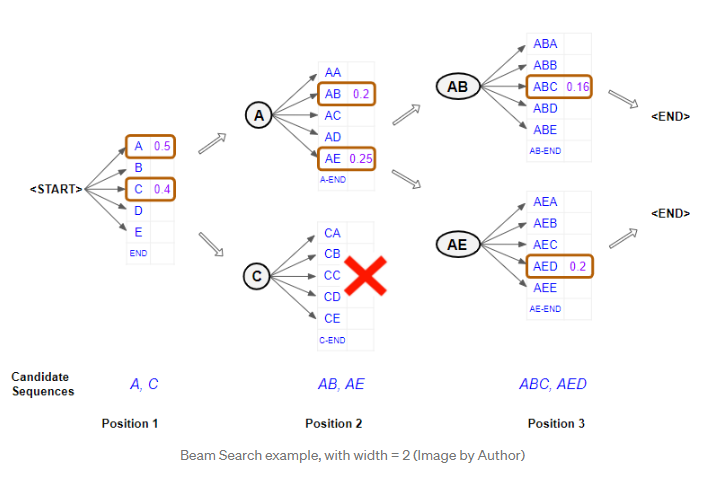

**First Position**

Consider the output of the model at the first position. It starts with the “\<START>” token and obtains probabilities for each word. It now selects the two best characters in that position. eg. “A” and “C”.

**Second Position**

When it comes to the second position, it re-runs the model twice to generate probabilities by fixing the possible characters in the first position. In other words, it constrains the characters in the first position to be either an “A” or a “C” and generates two branches with two sets of probabilities. The branch with the first set of probabilities corresponds to having “A” in position 1, and the branch with the second set corresponds to having “C” in position 1.

It now picks the overall two best character pairs based on the combined probability of the first two characters, from out of both sets of probabilities. So it doesn’t pick just one best character pair from the first set and one best character pair from the second set. eg. “AB” and “AE”

**Third Position**

When it comes to the third position, it repeats the process. It re-runs the model twice by constraining the first two positions to be either “AB” or “AE” and again generates two sets of probabilities.
Once more, it picks the overall two best character triplets based on the combined probability of the first three characters from both sets of probabilities. Therefore we now have the two best combinations of characters for the first three positions. eg. “ABC” and “AED”.

**Repeat till END token**

It continues doing this till it picks an "\<END>" token as the best character for some position, which then concludes that branch of the sequence.

It finally ends up with the two best sequences and predicts the one with the higher overall probability.

##### Beam Search Decoder - implementation

In [ ]:
# for pytorch model
def beam_search_decoder_KD(model, data, width, max_next_words=50, eos='</s>'):
  '''
  Args:
    data:  Tensor, shape (1, seq_len, batch_size, vocab_size) -  predicted probs,
    width: int -  number of beams
    max_next_words:  50
  Returns:
    str
  '''
  #sequences = [[list(), 0.0]]
  # walk over each step in sequence
  # bptt = 35
  # batch_size = 20
  # eval_batch_size = 10
  bptt = data.size[0]
  src_mask = generate_square_subsequent_mask(bptt).to(device)
i=1
data, targets = get_batch(test_data, i)
batch_size = data.size(0)
print("batch_size:", batch_size)
print("data.size()",data.size())
if batch_size != bptt:  # only on last batch
    src_mask = src_mask[:batch_size, :batch_size]
output = model(data, src_mask)

  beams = torch.tensor([[], [0.0]])
  for step in max_next_words:
    for beam in width:

  for row in data:
    all_candidates = list()
    # expand each current candidate
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        candidate = [seq + [j], score - math.log(row[j])]
        #candidate = [seq + [j], score - torch.log(row[j])]
        all_candidates.append(candidate)
		# order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences

In [ ]:
def tokenize_text(txt):
    return torch.tensor(vocab(tokenizer(txt)), dtype=torch.long)
tokenize_text('aaa blue')    

tensor([10310,   682])

In [ ]:
torch.asarray([1,2]), torch.tensor(seed_ids), vocab.get_itos()[0], vocab.get_itos()[6]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


(tensor([1, 2]), tensor([   8, 2484,  659]), '<unk>', 'in')

```
0. Init 
    seed text, tokenize, dataset, batchify
    max_next_words (max_steps)
    beam_width
    eos_id
    tracks[beam_width, []-probs, []-vocab_index]
    model
1. Step 1
    output = model.predict(seed_ids)
    probs, indices = torch.topk (output.view(batch_size*seg_len,vocab_size),
                                top_k=beam_width, dim=-1)
    for i in beam_width:
        tracks[i]["probs"] = probs[i]
        tracks[i]["indices"] = indices[i]

```

In [ ]:
max_next_words = 10
width = 2
bptt = 35
batch_size = 1
i=1
eos_id = 0
#data, targets = get_batch(test_data, i)
beams = torch.tensor([[], [0.0]])
start = 2
beams

seed_text = ["a finish"]
seed_ids = [torch.tensor(vocab(tokenizer(item.lower())), dtype=torch.long) for item in seed_text]
#seed_ids2 = torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
seed_text = "a finish"
seed_ids = torch.tensor(vocab(tokenizer(seed_text.lower())), dtype=torch.long)

data = seed_ids


#numel Returns the total number of elements in the input tensor
#print(seed_ids, seed_ids2)

# step 1
print("step 1")  
print(seed_ids)
seed_ids_ds = batchify(seed_ids, batch_size)
src_mask = generate_square_subsequent_mask(seed_ids.size(0)).to(device)
output = model(seed_ids_ds, src_mask)
#print(output.size())
#print(torch.topk(output,2, dim=-1))
probs_indices = torch.topk(output[-1,:,:], width, dim=-1)
#print(probs_indices)
"""
for probs, indices in list(zip(probs_indices[0], probs_indices[1])):
  #print(vocab.get_itos()[indices[0]])
  print(probs, indices)
  #print(indices[0], " ".join([ vocab.get_itos()[i] for i in indices[0]]))
  print(vocab.get_itos()[indices[0]])
"""
probs, indices = probs_indices[0][0],probs_indices[1][0]
print(probs, indices)

#tracks = torch.asarray([[[], 0.0],[[],0.0]])
tracks = {}
 
for beam in range(width):
  tracks[beam] = {}
  tracks[beam]["probs"] = [probs[beam].detach()]
  tracks[beam]["total_prob"] = probs[beam].detach()
  tracks[beam]["indices"] = [indices[beam]]
  tracks[beam]["ids"] = torch.cat((seed_ids, torch.tensor(tracks[beam]["indices"])) )
  tracks[beam]["text"]= " ".join([vocab.get_itos()[item] for item in tracks[beam]["ids"] ])
print("tracks", tracks)                        
print()

# step 2..end
for step in range(2,max_next_words+1,1):
  print("step", step)
  t_tracks = {}
  t_total_probs = {}
  max_probs_beams = width*[width*[-1]]
  #print("max_probs_beams", max_probs_beams)
  max_probs = torch.tensor(width*[-torch.inf])
  for beam in range(width):
    #seed_ids_ds = batchify(torch.cat((seed_ids,tracks[beam]["ids"])), batch_size)
    seed_ids_ds = batchify(tracks[beam]["ids"], batch_size)
    #src_mask = generate_square_subsequent_mask(tracks[beam]["ids"].size(0)).to(device)
    #src_mask = generate_square_subsequent_mask(torch.cat((seed_ids,tracks[beam]["ids"])).size(0)).to(device)
    src_mask = generate_square_subsequent_mask(tracks[beam]["ids"].size(0)).to(device)
    output = model(seed_ids_ds, src_mask)
    probs_indices = torch.topk(output[-1,:,:], width, dim=-1)
    probs, indices = probs_indices[0][0],probs_indices[1][0]
    t_tracks[beam] = {}
    t_total_probs[beam] = {}
    
    #t_total_probs[beam] = tracks[beam]["total_prob"]
    for beam2 in range(width):
      t_tracks[beam][beam2] = {}
      t_tracks[beam][beam2]["probs"] = probs[beam2].detach()
      #t_total_probs[beam][beam2]=tracks[beam]["total_prob"] + probs[beam2].detach() для более простой проверки
      t_total_probs[beam][beam2]=tracks[beam]["total_prob"] * probs[beam2].detach()
      t_tracks[beam][beam2]["indices"] = [indices[beam2]]
      t_tracks[beam][beam2]["ids"] = torch.cat((torch.tensor(tracks[beam]["ids"]), torch.tensor(t_tracks[beam][beam2]["indices"])) )
      t_tracks[beam][beam2]["text"]= " ".join([vocab.get_itos()[item] for item in t_tracks[beam][beam2]["ids"]])
      """
      if t_total_probs[beam][beam2] > max_probs[0]:
        max_probs_beams[0] = [beam, beam2]
        max_probs[0] = t_total_probs[beam][beam2]
      elif t_total_probs[beam][beam2] > max_probs[1]:
        t_total_probs[beam][beam2] = [beam, beam2]
        max_probs[1] = t_total_probs[beam][beam2]
      t_tracks[beam][beam2]["indices"] = [indices[beam2]]
      """
  print("t_tracks",t_tracks)        
  print("t_total_probs", t_total_probs)   
  # t_total_probs_t = [ vv for v in t_total_probs.values() for vv in v.values()]
  #torch.topk(torch.tensor(t_total_probs.values().numpy()), width, dim=-1)             

  for beam in range(width):
    for beam2 in range(width):
      if t_total_probs[beam][beam2]> max_probs[beam]:
        max_probs[beam] = t_total_probs[beam][beam2]
        max_probs_beams[beam] = [beam,beam2]
  print("max_probs_beams", max_probs_beams)
  print("max_probs", max_probs)
  
  for beam in range(width):
    tracks[beam]["ids"] = t_tracks[beam][max_probs_beams[beam][1]]["ids"] # полная запись
    tracks[beam]["indices"] += t_tracks[beam][max_probs_beams[beam][1]]["indices"]
    tracks[beam]["probs"] += [t_tracks[beam][max_probs_beams[beam][1]]["probs"]]
    #tracks[beam]["total_prob"] += t_tracks[beam][max_probs_beams[beam][1]]["probs"]
    tracks[beam]["total_prob"] = t_total_probs[beam][max_probs_beams[beam][1]]
    tracks[beam]["text"]= " ".join([vocab.get_itos()[item] for item in tracks[beam]["ids"]])
  print("tracks",tracks)
  print()
max_prob = -torch.inf
for beam in range(width):
  if tracks[beam]["total_prob"] > max_prob:
    max_prob = tracks[beam]["total_prob"]
    text = tracks[beam]["text"]
print("seed_text", seed_text)
print(max_prob, text)

step 1
tensor([   8, 2484])
tensor([11.9294, 11.3073], grad_fn=<SelectBackward0>) tensor([6, 4])
tracks {0: {'probs': [tensor(11.9294)], 'total_prob': tensor(11.9294), 'indices': [tensor(6)], 'ids': tensor([   8, 2484,    6]), 'text': 'a finish in'}, 1: {'probs': [tensor(11.3073)], 'total_prob': tensor(11.3073), 'indices': [tensor(4)], 'ids': tensor([   8, 2484,    4]), 'text': 'a finish of'}}

step 2
t_tracks {0: {0: {'probs': tensor(13.1476), 'indices': [tensor(1)], 'ids': tensor([   8, 2484,    6,    1]), 'text': 'a finish in the'}, 1: {'probs': tensor(11.0377), 'indices': [tensor(8)], 'ids': tensor([   8, 2484,    6,    8]), 'text': 'a finish in a'}}, 1: {0: {'probs': tensor(12.2472), 'indices': [tensor(1)], 'ids': tensor([   8, 2484,    4,    1]), 'text': 'a finish of the'}, 1: {'probs': tensor(10.0670), 'indices': [tensor(27)], 'ids': tensor([   8, 2484,    4,   27]), 'text': 'a finish of his'}}}
t_total_probs {0: {0: tensor(156.8434), 1: tensor(131.6735)}, 1: {0: tensor(138.4817

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


t_tracks {0: {0: {'probs': tensor(11.1688), 'indices': [tensor(95)], 'ids': tensor([   8, 2484,    6,    1,   95]), 'text': 'a finish in the second'}, 1: {'probs': tensor(11.0964), 'indices': [tensor(37)], 'ids': tensor([   8, 2484,    6,    1,   37]), 'text': 'a finish in the first'}}, 1: {0: {'probs': tensor(11.0025), 'indices': [tensor(37)], 'ids': tensor([   8, 2484,    4,    1,   37]), 'text': 'a finish of the first'}, 1: {'probs': tensor(10.6824), 'indices': [tensor(95)], 'ids': tensor([   8, 2484,    4,    1,   95]), 'text': 'a finish of the second'}}}
t_total_probs {0: {0: tensor(1751.7600), 1: tensor(1740.4050)}, 1: {0: tensor(1523.6472), 1: tensor(1479.3180)}}
max_probs_beams [[0, 0], [1, 0]]
max_probs tensor([1751.7600, 1523.6472])
tracks {0: {'probs': [tensor(11.9294), tensor(13.1476), tensor(11.1688)], 'total_prob': tensor(1751.7600), 'indices': [tensor(6), tensor(1), tensor(95)], 'ids': tensor([   8, 2484,    6,    1,   95]), 'text': 'a finish in the second'}, 1: {'probs'

In [ ]:
np.array(t_total_probs), list(t_total_probs.values()), [ vv for v in t_total_probs.values() for vv in v.values()]

#### Beam Search v 03 HuggingFace
https://huggingface.co/blog/how-to-generate

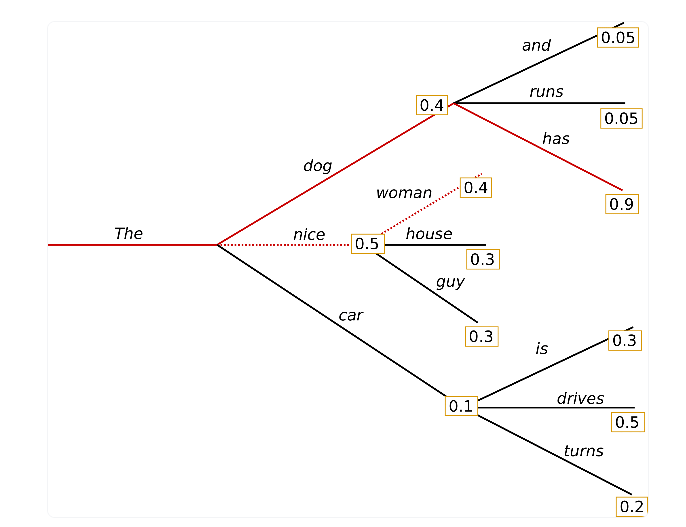

Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Let's illustrate with num_beams=2:

At time step 1, besides the most likely hypothesis ("The","nice"), beam search also keeps track of the second most likely one ("The","dog"). At time step 2, beam search finds that the word sequence ("The","dog","has"), has with 0.360.36 a higher probability than ("The","nice","woman"), which has 0.20.2 . Great, it has found the most likely word sequence in our toy example!

Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output.

### example Top-K Top-P sampling implementation
https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
https://programmersought.com/article/42077545764/


In [ ]:
# The code input is logits, and the consideration is very thorough (I feel that I missed the consideration of both k and p, which should be inappropriate)
# Clever use of torch.cumsum
# Avoid the embarrassing situation where you can't choose a word
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            Make sure we keep at least min_tokens_to_keep per batch example in the output
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

In [ ]:
#Look at repeated punishment

# The input is also logits (lprobs)
# At the same time input the words that appeared before and the penalty coefficient (greater than 1)
# Taking into account that logit is positive and negative, the processing method should be different
def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
    """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
    for i in range(batch_size * num_beams):
        for previous_token in set(prev_output_tokens[i].tolist()):
            # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
            if lprobs[i, previous_token] < 0:
                lprobs[i, previous_token] *= repetition_penalty
            else:
                lprobs[i, previous_token] /= repetition_penalty

In [ ]:
# The last is repeated word removal

# This function will return an unusable vocabulary
# You can learn from the clever way to generate n-gram
# Below is a 3-gram example
# a = [1,2,3,4,5]
# for ngram in zip(*[a[i:] for i in range(3)]):
#    print(ngram)
def calc_banned_tokens(prev_input_ids, num_hypos, no_repeat_ngram_size, cur_len):
    # Copied from fairseq for no_repeat_ngram in beam_search"""
    if cur_len + 1 < no_repeat_ngram_size:
        # return no banned tokens if we haven't generated no_repeat_ngram_size tokens yet
        return [[] for _ in range(num_hypos)]
    generated_ngrams = [{} for _ in range(num_hypos)]
    for idx in range(num_hypos):
        gen_tokens = prev_input_ids[idx].numpy().tolist()
        generated_ngram = generated_ngrams[idx]
        # Is this clever sentence
        for ngram in zip(*[gen_tokens[i:] for i in range(no_repeat_ngram_size)]):
            prev_ngram_tuple = tuple(ngram[:-1])
            generated_ngram[prev_ngram_tuple] = generated_ngram.get(prev_ngram_tuple, []) + [ngram[-1]]

    def _get_generated_ngrams(hypo_idx):
        # Before decoding the next token, prevent decoding of ngrams that have already appeared
        start_idx = cur_len + 1 - no_repeat_ngram_size
        ngram_idx = tuple(prev_input_ids[hypo_idx, start_idx:cur_len].numpy().tolist())
        return generated_ngrams[hypo_idx].get(ngram_idx, [])

    banned_tokens = [_get_generated_ngrams(hypo_idx) for hypo_idx in range(num_hypos)]
    return banned_tokens

In [ ]:
do_sample = True
if do_sample:
    # This is the sampling method today
    _scores = scores + beam_scores[:, None].expand_as(scores)  # (batch_size * num_beams, vocab_size)
    # Top-p/top-k filtering, this step reconstructs the candidate set
    _scores = top_k_top_p_filtering(
        _scores, top_k=top_k, top_p=top_p, min_tokens_to_keep=2
    )  # (batch_size * num_beams, vocab_size)
    # re-organize to group the beam together to sample from all beam_idxs
    _scores = _scores.contiguous().view(
        batch_size, num_beams * vocab_size
    )  # (batch_size, num_beams * vocab_size)

    # Sample 2 next tokens for each beam (so we have some spare tokens and match output of greedy beam search)
    probs = F.softmax(_scores, dim=-1)
    # Sampling
    next_tokens = torch.multinomial(probs, num_samples=2 * num_beams)  # (batch_size, num_beams * 2)
    # Compute next scores
    next_scores = torch.gather(_scores, -1, next_tokens)  # (batch_size, num_beams * 2)
    # sort the sampled vector to make sure that the first num_beams samples are the best
    next_scores, next_scores_indices = torch.sort(next_scores, descending=True, dim=1)
    next_tokens = torch.gather(next_tokens, -1, next_scores_indices)  # (batch_size, num_beams * 2)
else:
    # This is yesterday's beam search method
    # Directly add log probability to find conditional probability
    next_scores = scores + beam_scores[:, None].expand_as(scores)  # (batch_size * num_beams, vocab_size)

    # re-organize to group the beam together (we are keeping top hypothesis accross beams)
    next_scores = next_scores.view(
        batch_size, num_beams * vocab_size
    )  # (batch_size, num_beams * vocab_size)

    next_scores, next_tokens = torch.topk(next_scores, 2 * num_beams, dim=1, largest=True, sorted=True)

NameError: ignored